In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline
import glob

sns.set_theme(style='darkgrid')

import statsmodels as sm
from sklearn.metrics import mean_absolute_error, accuracy_score

In [3]:
columns_list = ['year', 'jday', 'month', 'day', 'hour', 'min', 'dt', 'zen', 'dw_solar', 'uw_solar', 'direct_n', 'diffuse', 'dw_ir', 
           'dw_casetemp', 'dw_dometemp', 'uw_irl', 'uw_casetemp', 'uw_dometemp', 'uvb', 'par', 'netsolar', 'netir', 
           'totalnet', 'temp', 'rh', 'windspd', 'winddir', 'pressure']

locations = ['Bondville_IL', 'Boulder_CO', 'Desert_Rock_NV', 'Fort_Peck_MT', 'Goodwin_Creek_MS', 'Penn_State_PA', 'Sioux_Falls_SD']

In [4]:
df_train = {}
df_test = {}
for location in locations:
    print(print(f"Reading Dataframes from {location}'..."))
    
    path = f"D:/Machine_Learning/NOAA/surfrad/to_csv/"
    
    df_train[location] = pd.read_csv(path + f"df_train_5yrs_{location}.csv")
    df_test[location] = pd.read_csv(path + f"df_test_{location}.csv")
print("Done!")

Reading Dataframes from Bondville_IL'...
None
Reading Dataframes from Boulder_CO'...
None
Reading Dataframes from Desert_Rock_NV'...
None
Reading Dataframes from Fort_Peck_MT'...
None
Reading Dataframes from Goodwin_Creek_MS'...
None
Reading Dataframes from Penn_State_PA'...
None
Reading Dataframes from Sioux_Falls_SD'...
None
Done!


In [19]:
df_train['Bondville_IL'].head()

Unnamed: 0    year  jday  month  day  hour  minute  \
0  2016-01-01 00:00:00+00:00  2016.0   1.0    1.0  1.0   0.0    29.5   
1  2016-01-01 01:00:00+00:00  2016.0   1.0    1.0  1.0   1.0    29.5   
2  2016-01-01 02:00:00+00:00  2016.0   1.0    1.0  1.0   2.0    29.5   
3  2016-01-01 03:00:00+00:00  2016.0   1.0    1.0  1.0   3.0    29.5   
4  2016-01-01 04:00:00+00:00  2016.0   1.0    1.0  1.0   4.0    29.5   

         dt  solar_zenith       ghi  ...       dw_ir       uw_ir  uvb  par  \
0  0.491667    110.587333 -3.650000  ...  222.186667  296.276667  0.0  0.2   
1  1.491667    121.901500 -3.723333  ...  216.428333  292.766667  0.0  0.2   
2  2.491667    133.348667 -3.948333  ...  217.558333  295.066667  0.0  0.2   
3  3.491667    144.565167 -4.195000  ...  217.885000  297.173333  0.0  0.2   
4  4.491667    154.756667 -3.860000  ...  216.563333  296.508333  0.0  0.2   

   netsolar      netir   totalnet  temp_air  relative_humidity     pressure  
0       0.0 -74.090000 -74.090000 -2.611667          79.911667  1001.551667  
1       0.0 -76.355000 -76.355000 -3.183333          85.548333  1001.323333  
2       0.0 -77.506667 -77.506667 -3.085000          86.496667  1001.458333  
3       0.0 -79.290000 -79.290000 -2.845000          87.973333  1001.256667  
4       0.0 -79.950000 -79.950000 -3.040000          88.921667  1000.926667  

[5 rows x 23 columns]

In [14]:
# Quick and dirty interpolation to replace nan values
for location in locations:
    df_train[location].interpolate(method='linear', inplace=True)
    

In [20]:
def format_index(data):
    """Create UTC localized DatetimeIndex for the dataframe.
    Parameters
    ----------
    data: Dataframe
        Must contain columns 'year', 'jday', 'hour' and
        'minute'.
    Return
    ------
    data: Dataframe
        Dataframe with a DatetimeIndex localized to UTC.
    """
    year = data.year.astype(int).apply(str)
    jday = data.jday.astype(int).apply(lambda x: '{:03d}'.format(x))
    hours = data.hour.astype(int).apply(lambda x: '{:02d}'.format(x))
    minutes = data.minute.astype(int).apply(lambda x: '{:02d}'.format(x))
    index = pd.to_datetime(year + jday + hours + minutes, format="%Y%j%H%M")
    data.index = index
    data = data.tz_localize('UTC')

    return data

In [21]:
for location in locations:    
    format_index(df_train[location])
    format_index(df_test[location])
    
    df_train[location].drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'minute', 'dt'], inplace=True)
    df_test[location].drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'minute', 'dt'], inplace=True)

We keep 'jday' and 'hour' as they can be correlated to the solar irradiance!

In [24]:
# Sanity check for datetime index
df_train['Bondville_IL'].index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', length=43848)

In [28]:
df_train['Bondville_IL'].head()

jday  hour  solar_zenith       ghi  uw_solar       dni  \
2016-01-01 00:29:00   1.0   0.0    110.587333 -3.650000  0.028333  0.625000   
2016-01-01 01:29:00   1.0   1.0    121.901500 -3.723333 -0.226667  1.498333   
2016-01-01 02:29:00   1.0   2.0    133.348667 -3.948333 -0.400000  1.323333   
2016-01-01 03:29:00   1.0   3.0    144.565167 -4.195000 -0.280000  1.010000   
2016-01-01 04:29:00   1.0   4.0    154.756667 -3.860000 -0.073333  0.713333   

                          dhi       dw_ir       uw_ir  uvb  par  netsolar  \
2016-01-01 00:29:00 -0.253333  222.186667  296.276667  0.0  0.2       0.0   
2016-01-01 01:29:00 -0.346667  216.428333  292.766667  0.0  0.2       0.0   
2016-01-01 02:29:00 -0.393333  217.558333  295.066667  0.0  0.2       0.0   
2016-01-01 03:29:00 -0.395000  217.885000  297.173333  0.0  0.2       0.0   
2016-01-01 04:29:00 -0.400000  216.563333  296.508333  0.0  0.2       0.0   

                         netir   totalnet  temp_air  relative_humidity  \
2016-01-01 00:29:00 -74.090000 -74.090000 -2.611667          79.911667   
2016-01-01 01:29:00 -76.355000 -76.355000 -3.183333          85.548333   
2016-01-01 02:29:00 -77.506667 -77.506667 -3.085000          86.496667   
2016-01-01 03:29:00 -79.290000 -79.290000 -2.845000          87.973333   
2016-01-01 04:29:00 -79.950000 -79.950000 -3.040000          88.921667   

                        pressure  
2016-01-01 00:29:00  1001.551667  
2016-01-01 01:29:00  1001.323333  
2016-01-01 02:29:00  1001.458333  
2016-01-01 03:29:00  1001.256667  
2016-01-01 04:29:00  1000.926667

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_train['Bondville_IL'].index,
                        y=df_train['Bondville_IL'].netsolar,
                        name='Training Data'),       
              )

fig.update_layout(title='Net Solar Radiation')

fig.show()

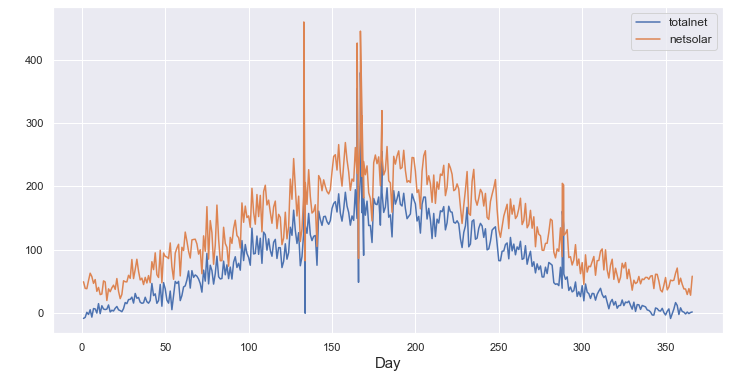

In [29]:
plt.figure(figsize=(12,6))
# sns.lineplot(data=dfs['Bondville_IL'], x='jday', y='totalnet', color='r')
# sns.lineplot(data=dfs['Bondville_IL'], x='jday', y='netsolar', color='green')
sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='totalnet')
sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='netsolar')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
plt.legend(['totalnet', 'netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

In [ ]:
# Checking null values across all the dataframes
null_dict = {}
for location in locations:
    null_dict[location] = df_train[location].isna().sum()
df_null = pd.DataFrame(null_dict)
df_null

In [9]:
# Quick and dirty interpolation to replace nan values
for location in locations:
    df_train[location].interpolate(method='linear', inplace=True)

In [11]:
null_dict = {}
for location in locations:
    null_dict[location] = df_train[location].isna().sum()
df_null = pd.DataFrame(null_dict)
df_null.isna().sum()

Bondville_IL        0
Boulder_CO          0
Desert_Rock_NV      0
Fort_Peck_MT        0
Goodwin_Creek_MS    0
Penn_State_PA       0
Sioux_Falls_SD      0
dtype: int64

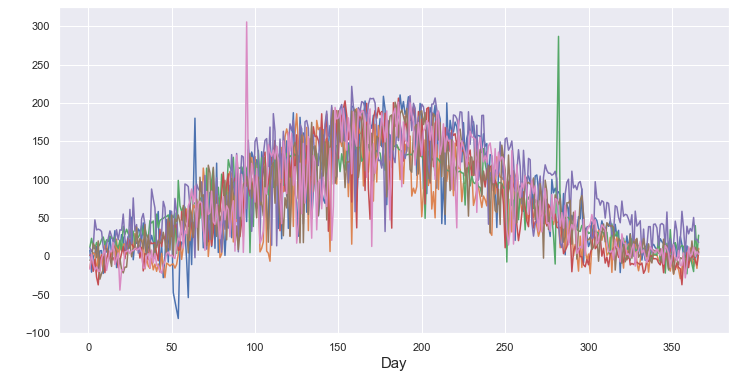

In [17]:
plt.figure(figsize=(12,6))
for location in locations:
    sns.lineplot(data=df_train[location].groupby('jday').mean(), x='jday', y='totalnet')
# sns.lineplot(data=df_train['Bondville_IL'], x='jday', y='totalnet', color='r')
# sns.lineplot(data=df_train['Bondville_IL'], x='jday', y='netsolar', color='green')
# sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='totalnet')
# sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='netsolar')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
# plt.legend(['totalnet', 'netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

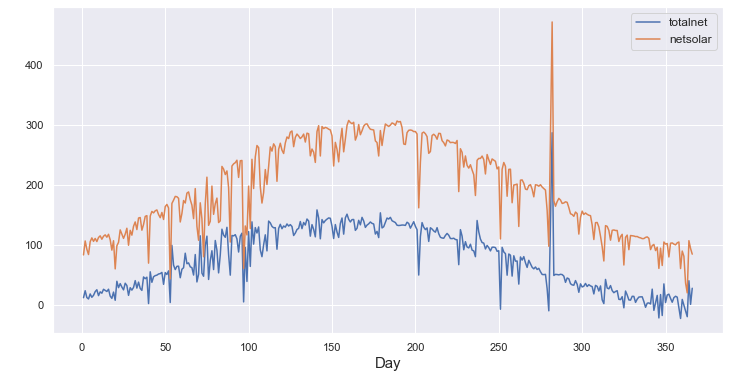

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_train['Desert_Rock_NV'].groupby('jday').mean(), x='jday', y='totalnet')
sns.lineplot(data=df_train['Desert_Rock_NV'].groupby('jday').mean(), x='jday', y='netsolar')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
plt.legend(['totalnet', 'netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

There are outliers in the data, we need to detect them and clean them.
But for now, lets do standard check on time series data.

## Data Split

In [14]:
# Create Training Data
def data_split(df_train, df_test, location='Bondville_IL', frequency='daily'):
    '''
    Simple function to split data into training/test/validation set
    Also, split based on hourly/daily/monthly aggregates
    '''
    if frequency == 'hourly':
        train = df_train[location].resample('H').mean()
        test_split = int((df_test[location].resample('H').mean().shape[0])/2)        
        val = df_test[location].resample('H').mean()[0:test_split]
        test = df_test[location].resample('H').mean()[test_split:]
        
    elif frequency=='daily':
        train = df_train[location].resample('D').mean()
        test_split = int((df_test[location].resample('D').mean().shape[0])/2)
        val = df_test[location].resample('D').mean()[0:test_split]
        test = df_test[location].resample('D').mean()[test_split:]      
    
    elif frequency=='monthly':
        train = df_train[location].resample('MS').mean()
        test_split = int((df_test[location].resample('MS').mean().shape[0])/2)
        val = df_test[location].resample('MS').mean()[0:test_split]
        test = df_test[location].resample('MS').mean()[test_split:]    
        
    return train, val, test

In [15]:
# split with daily aggregate

train_d, val_d, test_d = {}, {}, {}
train_h, val_h, test_h = {}, {}, {}
for location in locations: 
    train_d[location], val_d[location], test_d[location] = data_split(df_train, df_test, location, frequency='daily')
    train_h[location], val_h[location], test_h[location] = data_split(df_train, df_test, location, frequency='hourly')

### Stationarity Check

In [50]:
# Store rolling mean and standard deviation in a dictionary.
# h: for hourly and d: for daily

roll_mean_h, roll_std_h = {}, {}
roll_mean_d, roll_std_d = {}, {}

for location in locations:  
    # 10 days rolling average
    roll_mean_d[location] = train_d[location].rolling(window=10, center=False).mean()
    roll_std_d[location] = train_d[location].rolling(window=10, center=False).std()
    roll_mean_d[location]['jday'] = train_d[location]['jday']
    roll_std_d[location]['jday'] = train_d[location]['jday']
    
    # 24 hour rolling average
    roll_mean_h[location] = train_h[location].rolling(window=24, center=False).mean()
    roll_std_h[location] = train_h[location].rolling(window=24, center=False).std()
    roll_mean_h[location]['jday'] = train_h[location]['jday']
    roll_std_h[location]['jday'] = train_h[location]['jday']

In [295]:
locations

['Bondville_IL',
 'Boulder_CO',
 'Desert_Rock_NV',
 'Fort_Peck_MT',
 'Goodwin_Creek_MS',
 'Penn_State_PA',
 'Sioux_Falls_SD']

In [307]:
import plotly.graph_objs as go

def roll_mean(train_dict, roll_mean_d):    
   
    fig = go.Figure()
    
#     fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
#                             y=train_dict['Bondville_IL'].netsolar,
#                             name='Training Data'),       
#                   )
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Bondville_IL'].netsolar,
                            name='Bondville_IL'),
                  )
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Boulder_CO'].netsolar,
                            name='Boulder_CO'),
                  )             
                 
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Desert_Rock_NV'].netsolar,
                            name='Desert_Rock_NV'),
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Fort_Peck_MT'].netsolar,
                            name='Fort_Peck_MT'), 
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Goodwin_Creek_MS'].netsolar,
                            name='Goodwin_Creek_MS'), 
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Penn_State_PA'].netsolar,
                            name='Penn_State_PA'),
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Sioux_Falls_SD'].netsolar,
                            name='Sioux_Falls_SD'), 
                  )

    fig.update_layout(title='10 Days Rolling Average of Net Solar Radiation')
                  
    fig.show()

In [308]:
roll_mean(train_d, roll_mean_d)

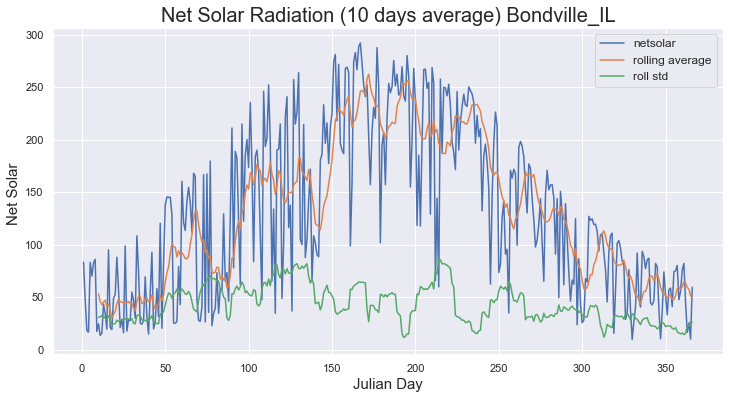

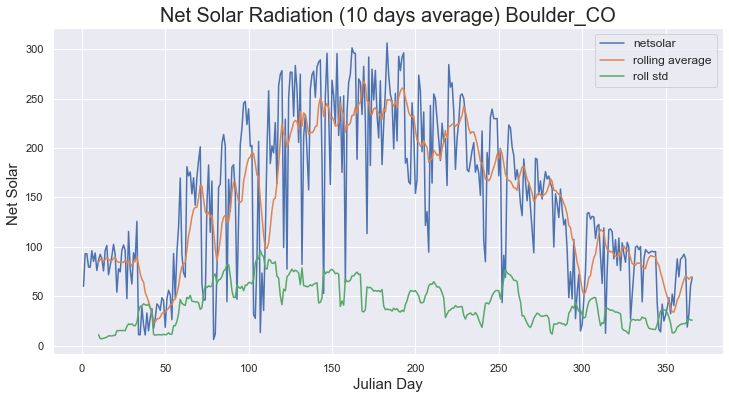

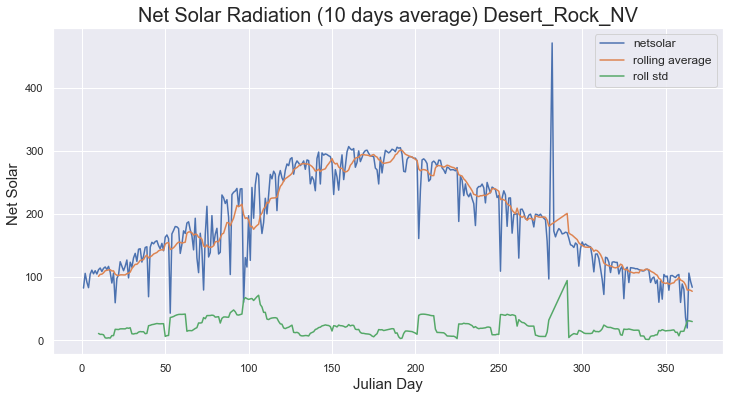

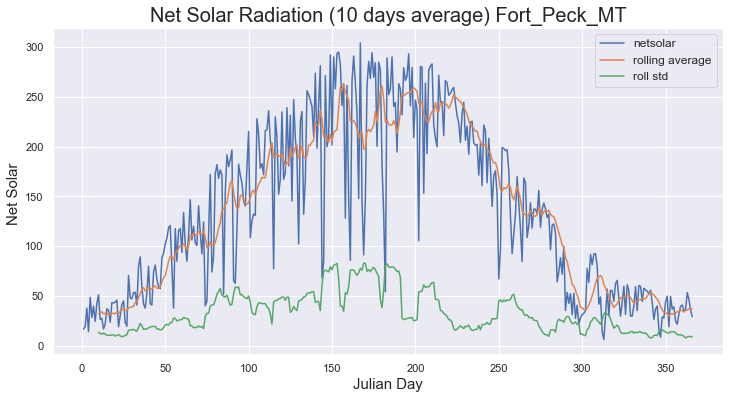

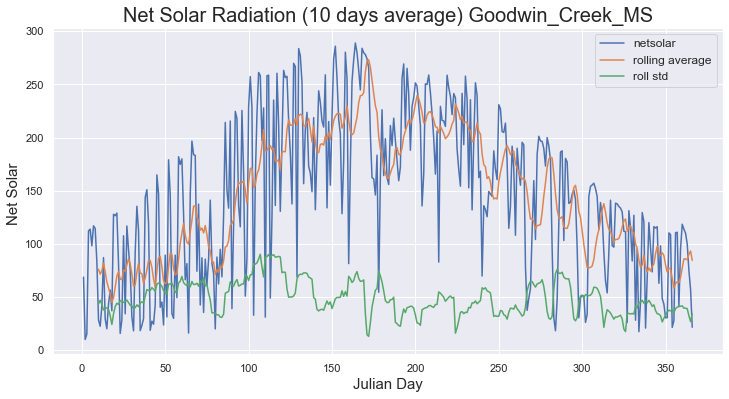

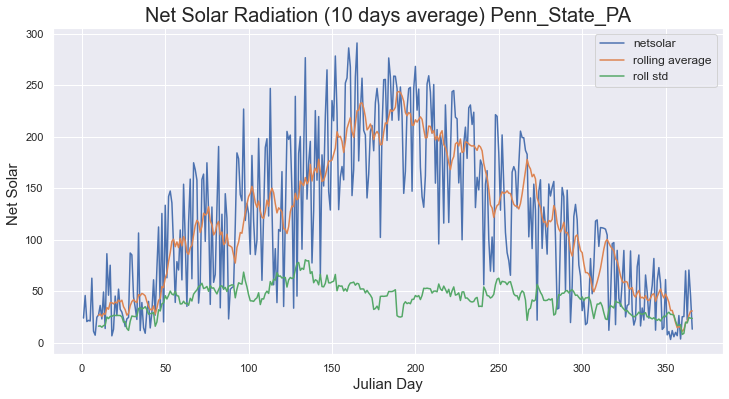

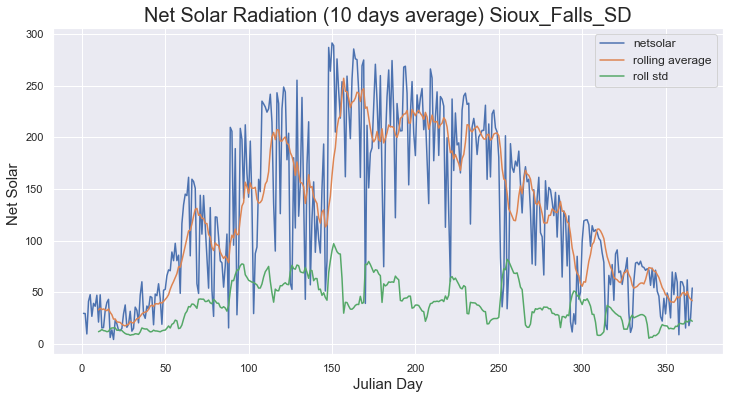

In [59]:
column = 'netsolar'

for location in locations:    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=train_d[location], x='jday', y=column)
    sns.lineplot(data=roll_mean_d[location], x='jday', y=column)
    sns.lineplot(data=roll_std_d[location], x='jday', y=column)

    plt.xlabel('Julian Day', fontsize=15)
    plt.ylabel('Net Solar ', fontsize=15)
    plt.legend([column, 'rolling average', 'roll std'], fontsize=12)
    plt.title(f'Net Solar Radiation (10 days average) {location}', fontsize=20)
    plt.show();

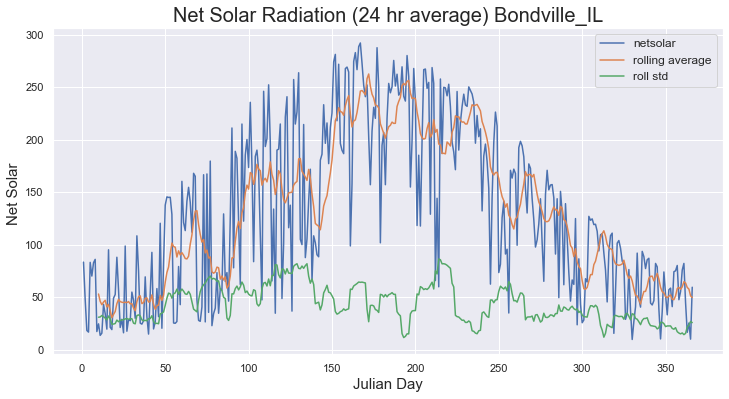

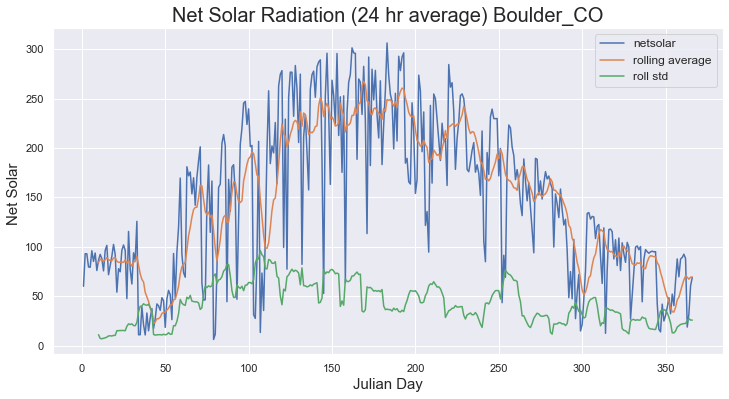

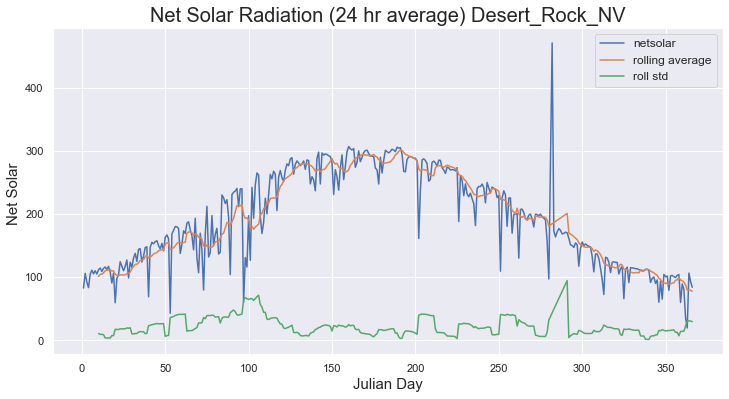

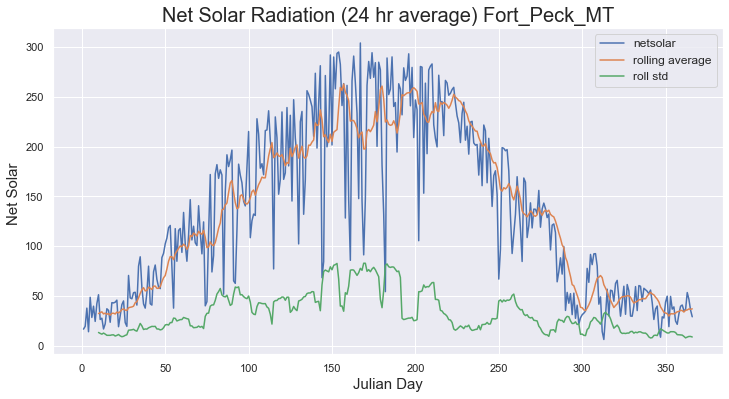

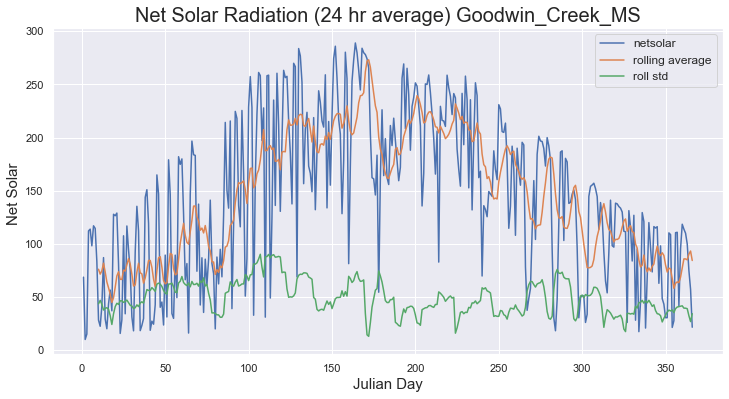

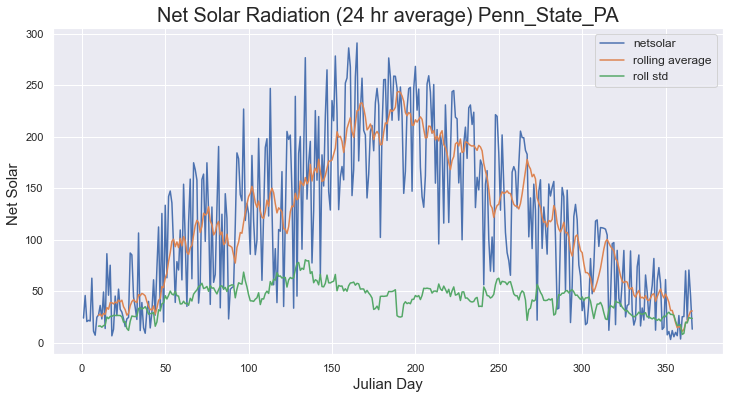

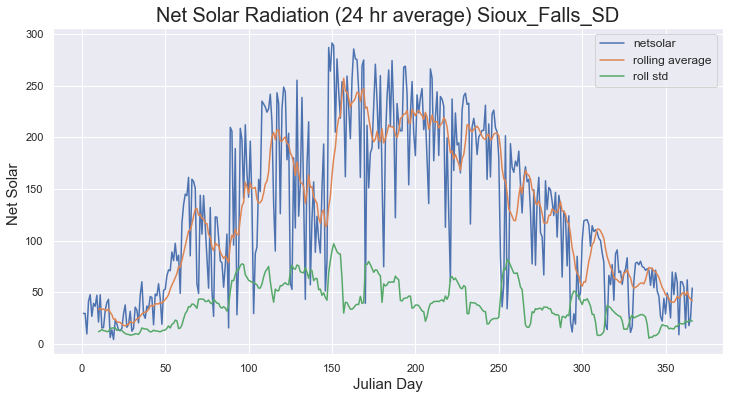

In [60]:
column = 'netsolar'

for location in locations:    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=train_d[location], x='jday', y=column)
    sns.lineplot(data=roll_mean_d[location], x='jday', y=column)
    sns.lineplot(data=roll_std_d[location], x='jday', y=column)

    plt.xlabel('Julian Day', fontsize=15)
    plt.ylabel('Net Solar ', fontsize=15)
    plt.legend([column, 'rolling average', 'roll std'], fontsize=12)
    plt.title(f'Net Solar Radiation (24 hr average) {location}', fontsize=20)
    plt.show();

### Test for Stationarity

In [81]:
train_d[location].fillna(0, inplace=True)
train_h[location].fillna(0, inplace=True)

In [70]:
from statsmodels.tsa.stattools import adfuller

In [71]:
def adf_test(df, signif=0.05):
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '# Observations'])
    for key, value in dftest[4].items():
        adf['Critical Value (%s) '%key] = value
    print(adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f"Series is Stationary")
    else:
        print(f"Series is Non-Stationary")

In [79]:
for location in locations:
    print('\n'+location)
    adf_test(train_d[location].netsolar)


Bondville_IL
Test Statistic            -1.702851
p-value                    0.429644
#Lags Used                10.000000
# Observations           355.000000
Critical Value (1%)       -3.448906
Critical Value (5%)       -2.869716
Critical Value (10%)      -2.571126
dtype: float64
Series is Non-Stationary

Boulder_CO
Test Statistic            -1.337090
p-value                    0.612038
#Lags Used                12.000000
# Observations           353.000000
Critical Value (1%)       -3.449011
Critical Value (5%)       -2.869763
Critical Value (10%)      -2.571151
dtype: float64
Series is Non-Stationary

Desert_Rock_NV
Test Statistic            -0.601915
p-value                    0.870549
#Lags Used                 9.000000
# Observations           356.000000
Critical Value (1%)       -3.448853
Critical Value (5%)       -2.869693
Critical Value (10%)      -2.571114
dtype: float64
Series is Non-Stationary

Fort_Peck_MT
Test Statistic            -0.952506
p-value                    0.770

In [82]:
for location in locations:
    print('\n'+location)
    adf_test(train_h[location].netsolar)


Bondville_IL
Test Statistic          -7.171742e+00
p-value                  2.792983e-10
#Lags Used               2.800000e+01
# Observations           8.755000e+03
Critical Value (1%)     -3.431097e+00
Critical Value (5%)     -2.861870e+00
Critical Value (10%)    -2.566946e+00
dtype: float64
Series is Stationary

Boulder_CO
Test Statistic          -7.019834e+00
p-value                  6.586909e-10
#Lags Used               2.600000e+01
# Observations           8.757000e+03
Critical Value (1%)     -3.431097e+00
Critical Value (5%)     -2.861870e+00
Critical Value (10%)    -2.566946e+00
dtype: float64
Series is Stationary

Desert_Rock_NV
Test Statistic             -4.673061
p-value                     0.000095
#Lags Used                 28.000000
# Observations           8755.000000
Critical Value (1%)        -3.431097
Critical Value (5%)        -2.861870
Critical Value (10%)       -2.566946
dtype: float64
Series is Stationary

Fort_Peck_MT
Test Statistic          -5.776694e+00
p-value

Data resampled to daily average is is not stationary, but resampled to hourly average stationary as indicated by extremely low p-value( << 0.05 ). 

### Test for causality

In [84]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [266]:
locations

['Bondville_IL',
 'Boulder_CO',
 'Desert_Rock_NV',
 'Fort_Peck_MT',
 'Goodwin_Creek_MS',
 'Penn_State_PA',
 'Sioux_Falls_SD']

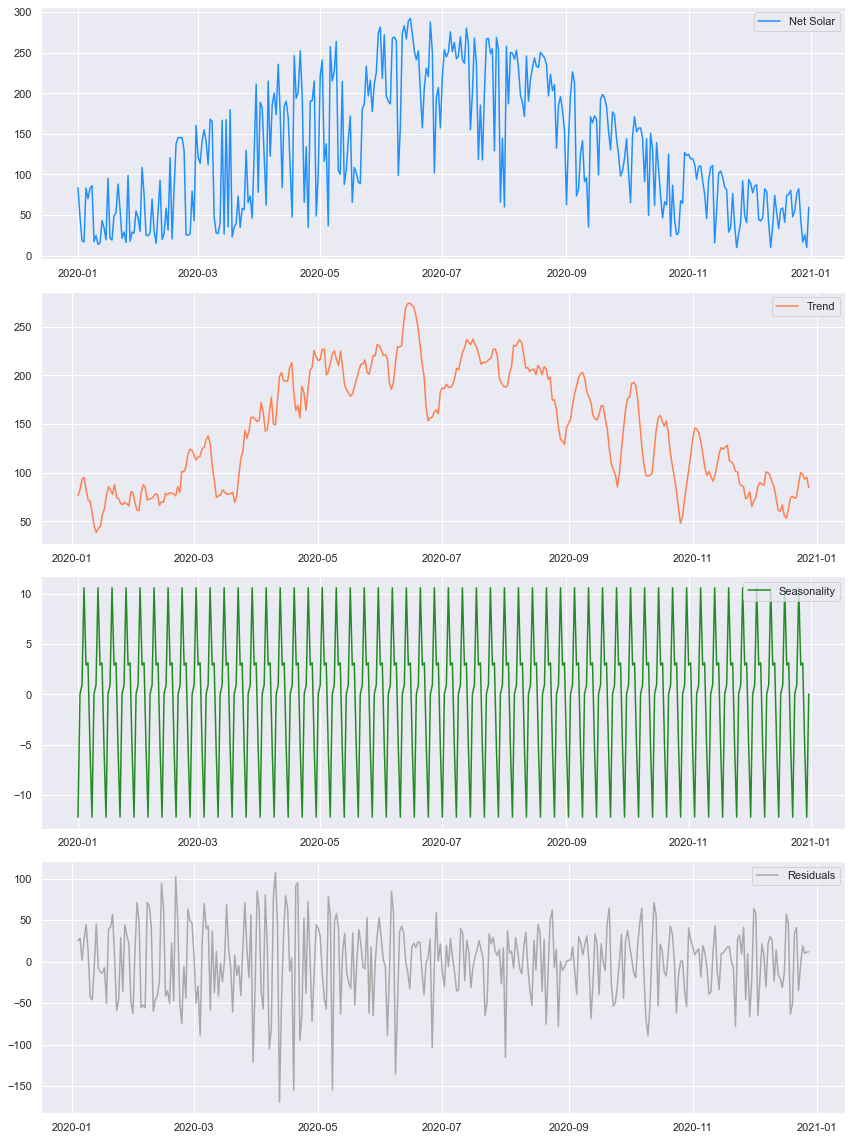

In [267]:
decomposition_d = seasonal_decompose(train_d['Goodwin_Creek_MS'].netsolar)

# Gather the trend, seasonality, and residuals 
trend = decomposition_d.trend
seasonal = decomposition_d.seasonal
residual = decomposition_d.resid

# Plot gathered statistics
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(train_d['Bondville_IL'].netsolar, label='Net Solar', color='dodgerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='coral')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='forestgreen')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkgrey')
plt.legend(loc='best')
plt.tight_layout()


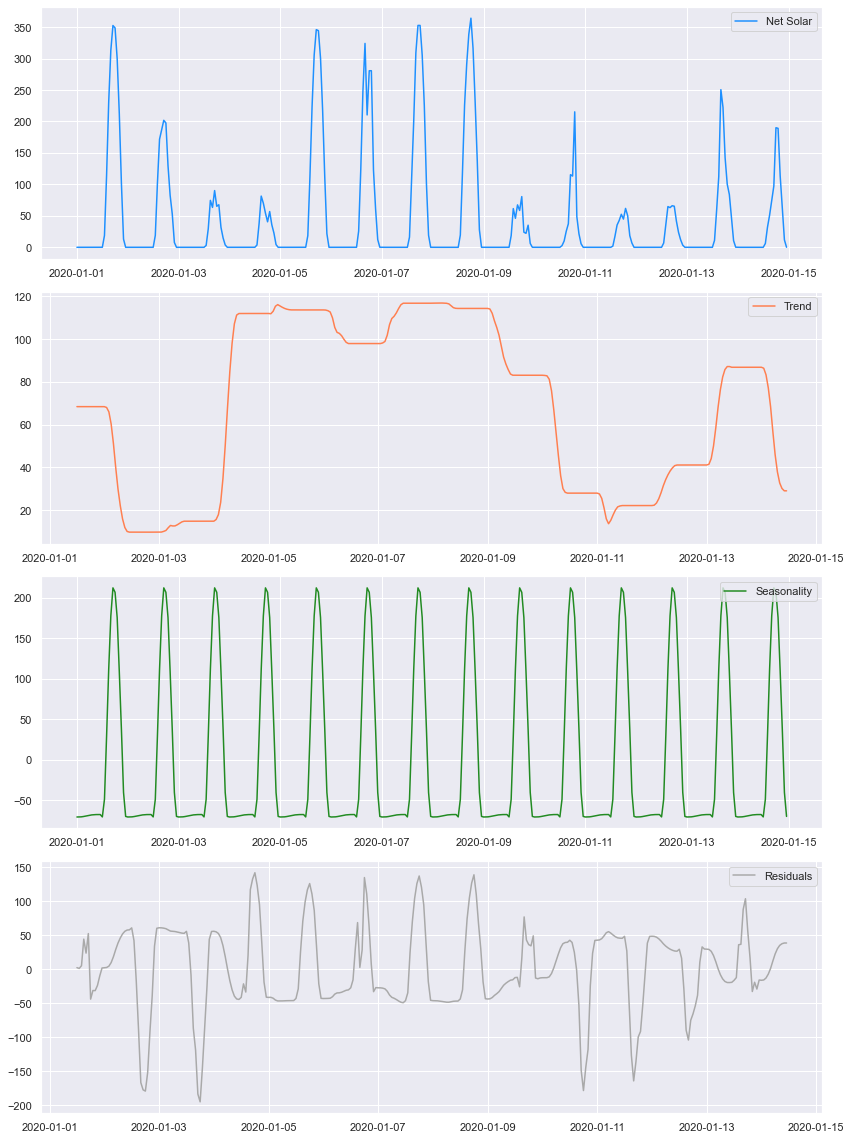

In [268]:
decomposition_h = seasonal_decompose(train_h['Goodwin_Creek_MS'].netsolar[0:336,])  # upto 14 days

# Gather the trend, seasonality, and residuals 
trend = decomposition_h.trend
seasonal = decomposition_h.seasonal
residual = decomposition_h.resid

# Plot gathered statistics
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(train_h['Bondville_IL'].netsolar[0:336,], label='Net Solar', color='dodgerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='coral')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='forestgreen')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkgrey')
plt.legend(loc='best')
plt.tight_layout()

Although, the adfuller test tells us no seasonality in the hourly dataset, there seems to be some seasonality in the dataset.

# Modelling

In [269]:
# Extract a univarate data for Arima modelling, hour and day
# We will start this experiment on one of the location

train_d_1d = train_d['Goodwin_Creek_MS']['netsolar']
test_d_1d = test_d['Goodwin_Creek_MS']['netsolar']

train_h_1d = train_h['Goodwin_Creek_MS']['netsolar']
test_h_1d = test_h['Goodwin_Creek_MS']['netsolar']

train_d_1d.shape, test_d_1d.shape, train_h_1d.shape, test_h_1d.shape

((366,), (74,), (8784,), (1764,))

In [109]:
# val_h = df_test['Bondville_IL'].resample('H').mean()['netsolar'][0:1752]
# test_h = df_test['Bondville_IL'].resample('H').mean()['netsolar'][1752:]

# train_d = df_train['Bondville_IL'].resample('D').mean()['netsolar'].fillna(0)
# val_d = df_test['Bondville_IL'].resample('D').mean()['netsolar'][0:1752]
# test_d = df_test['Bondville_IL'].resample('D').mean()['netsolar'][1752:]

# val_h.fillna(0, inplace=True)
# val_d.fillna(0, inplace=True)

In [270]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

<AxesSubplot:>

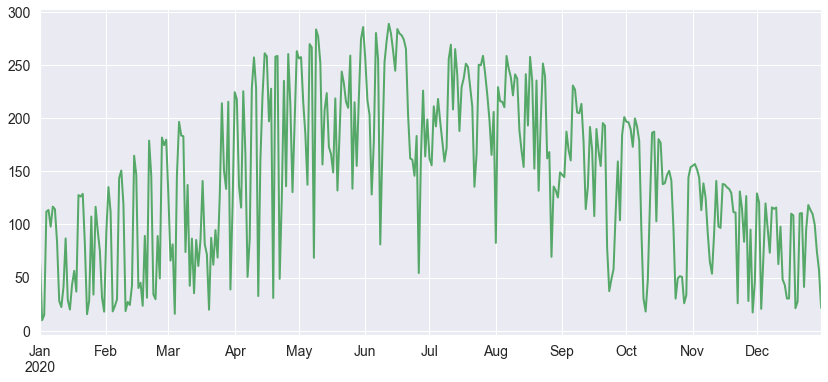

In [271]:
train_d_1d.plot(figsize=(14,6), linewidth=2, fontsize=14, color='g')

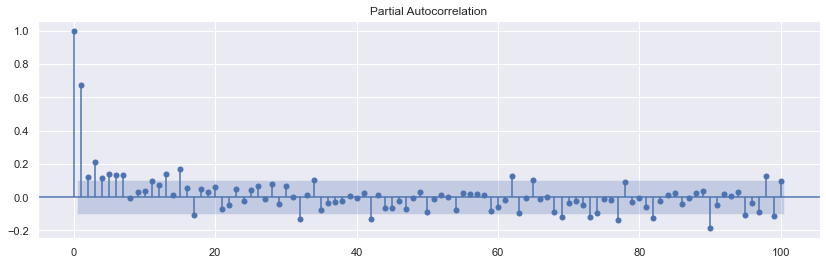

In [272]:
fig, ax = plt.subplots(figsize=(14,4))
plot_pacf(train_d_1d, ax=ax, lags=100);

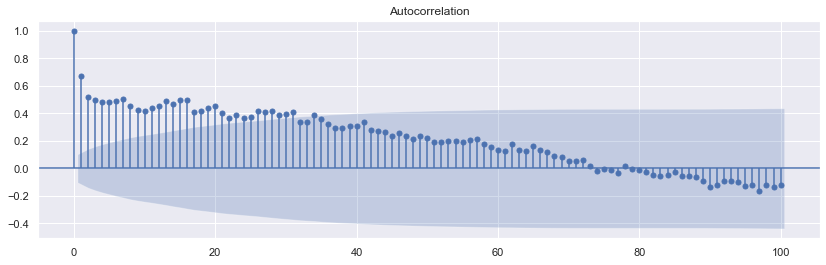

In [273]:
fig, ax = plt.subplots(figsize=(14,4))
plot_acf(train_d_1d, ax=ax, lags=100);

### ARIMA

In [274]:
from statsmodels.tsa.arima.model import ARIMA

                               SARIMAX Results                                
Dep. Variable:               netsolar   No. Observations:                  366
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -1961.891
Date:                Mon, 14 Jun 2021   AIC                           3939.782
Time:                        00:21:38   BIC                           3971.003
Sample:                    01-01-2020   HQIC                          3952.189
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.6800     44.136      3.165      0.002      53.176     226.184
ar.L1          1.3526      0.065     20.873      0.000       1.226       1.480
ar.L2         -0.4694      0.081     -5.784      0.0

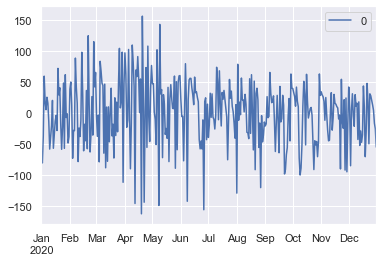

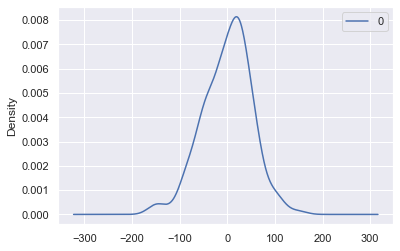

In [275]:
arima = ARIMA(train_d_1d, order=(5,0,1)).fit()
print(arima.summary())
residuals = pd.DataFrame(arima.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [276]:
df_arima_pred = pd.DataFrame(val_d['Bondville_IL'].netsolar, columns=['netsolar'])
pred_arima = arima.predict(start='2021-01-01', end='2021-08-01')
pred_arima_np = pd.Series(np.array(pred_arima).reshape(-1))

df_arima_temp = pd.DataFrame(df_arima_pred).reset_index()
df_arima_temp['predicted'] = pd.Series(pred_arima_np, index = df_arima_temp.index)

df_arima_pred['predict_arima'] = df_arima_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima
2021-01-01  11.735000      60.210796
2021-01-02  20.541458      79.190262
2021-01-03  14.311597      81.518166
2021-01-04  21.697500      83.984605
2021-01-05  26.341181      83.526857

In [277]:
import plotly.graph_objs as go

def arima_forecast(train_df, val_df, pred_df):    
   
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=train_df.index,
                            y=train_df,
                            name='Training Data'),       
                         )
    fig.add_trace(go.Scatter(x=val_df.index,
                            y=val_df,
                            name='Ground Truth'),       
                         )
    fig.add_trace(go.Scatter(x=pred_df.index,
                            y=pred_df,
                            name='Forecast'),       
                         )


    fig.update_layout(title='Forecast of Net Solar Radiation')
    fig.show()

In [278]:
arima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_arima'] )

So, we can see that the ARIMA model is not so effective in predicting in realistic manner. Although, we saw some seasonality aspect in the data but we didnt account for it in the modelling yet.In the next step, we will try to experiment with SARIMAX which will account for the seasonal aspect of the data.

### SARIMAX

In [279]:
import statsmodels.api as sm

In [280]:
sarimax1 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,1,1),
                                    seasonal_order=(2,1,2,12), 
                                    )

# Fit the model and print results
sarimax1_results = sarimax1.fit()
print(sarimax1_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3450      0.060      5.761      0.000       0.228       0.462
ma.L1         -0.9220      0.029    -31.553      0.000      -0.979      -0.865
ar.S.L12       0.5884      0.712      0.826      0.409      -0.807       1.984
ar.S.L24      -0.0455      0.074     -0.613      0.540      -0.191       0.100
ma.S.L12      -1.5452      0.706     -2.189      0.029      -2.929      -0.162
ma.S.L24       0.5788      0.668      0.867      0.386      -0.730       1.887
sigma2      2821.1281    190.320     14.823      0.000    2448.108    3194.148


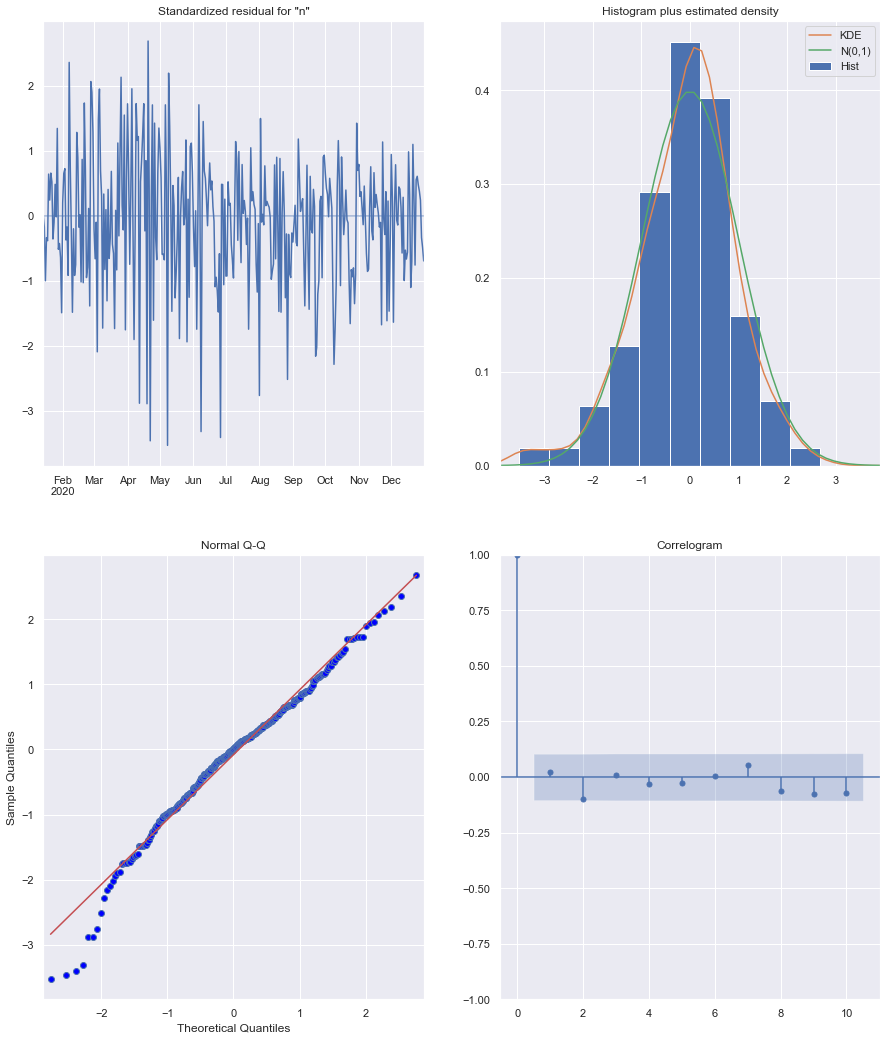

In [281]:
# Call plot_diagnostics() on the results calculated above 
sarimax1_results.plot_diagnostics(figsize=(15, 18))
plt.show()

In [282]:
pred_sarimax1 = sarimax1_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax1_np = pd.Series(np.array(pred_sarimax1).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax1_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax1'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1
2021-01-01  11.735000      60.210796         62.713554
2021-01-02  20.541458      79.190262         67.471738
2021-01-03  14.311597      81.518166         80.256039
2021-01-04  21.697500      83.984605         65.358192
2021-01-05  26.341181      83.526857         75.356192

In [283]:
import plotly.graph_objs as go

def sarima_forecast(train_df, val_df, pred1, pred2):    
   
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=train_df.index,
                            y=train_df,
                            name='Training Data'),       
                         )
    fig.add_trace(go.Scatter(x=val_df.index,
                            y=val_df,
                            name='Ground Truth'),       
                         )
    fig.add_trace(go.Scatter(x=pred1.index,
                            y=pred1,
                            name='Previous Forecast'),       
                         )
    fig.add_trace(go.Scatter(x=pred2.index,
                            y=pred2,
                            name='New Forecast'),       
                         )


    fig.update_layout(title='Forecast of Net Solar Radiation')
    fig.show()

In [284]:
sarima_forecast(train_d_1d, val_d['Goodwin_Creek_MS'].netsolar, df_arima_pred['predict_arima'],
               df_arima_pred['predict_sarimax1'])

Comparing to Arima, the sarimax model seems to better capture the trend in the granular manner. However, the current model hasn't yet able to generalize it better. In terms of generalization, the arima model is okay though it just depicts a linear style trend.

### Hyperparameter Searching

In [285]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q)) ]
print('Examples of parameter for SARIMAX...')
print('SARIMAX: {} x {}'.format(pdq[1], pdqs[1]))

Examples of parameter for SARIMAX...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [224]:
def sarimax_tuning(timeseries, seasonal_period):
    ''' 
    A simple function to grid search optimum paramters for SARIMAX
    An example of SARIMAX parameters: (0, 0, 1) x (0, 0, 1, 12)
    '''
    p = d = q = range(0,2)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    for param in pdq:
        for param_seasonal in pdqs:               
            try:
                model = sm.tsa.statespace.SARIMAX(timeseries,
                                                 order=param,
                                                 seasonal_order=param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False
                                                 )
                results = model.fit()

                if results.aic < mini:
                    param_mini = param
                    param_seasonal_mini = param_seasonal
                    #print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic}')
            except:
                continue
    print(f'The set of parameters with the minimum AIC is: SARIMAX{param_mini}x{param_seasonal_mini}-AIC:{mini}')

In [225]:
sarimax_tuning(train_d_1d, 12)

The set of parameters with the minimum AIC is: SARIMAX(1, 1, 1)x(1, 1, 1, 12)-AIC:inf


In [286]:
p = q = (0, 1, 2)
d = 0
pdq = [(ar, d, ma) for ar in p for ma in q]
pdqs = [(c[0], d, c[2], 12) for c in pdq]

# Iterate and try models:
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(train_d_1d,
                                             order=pdq_combo,
                                             seasonal_order=pdqs_combo,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False
                                             )
            output = model.fit()
            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                #print('Sarima Combos:', (pdq_combo, pdqs_combo), 'AIC:', output.aic)

        except ValueError:
            pass
print(f'\m{"*"*20}\nOptimal Sarima order: {combo}')  

\m********************
Optimal Sarima order: ((1, 0, 2), (0, 0, 2, 12))


In [287]:
sarimax2 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,0,2),
                                    seasonal_order=(0,0,2,12), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                    )

# Fit the model and print results
sarimax2_results = sarimax2.fit()
print(sarimax2_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.002    407.352      0.000       0.994       1.004
ma.L1         -0.5521      0.051    -10.885      0.000      -0.651      -0.453
ma.L2         -0.3161      0.048     -6.604      0.000      -0.410      -0.222
ma.S.L12      -0.0502      0.056     -0.902      0.367      -0.159       0.059
ma.S.L24      -0.0592      0.060     -0.983      0.326      -0.177       0.059
sigma2      2713.0881    210.724     12.875      0.000    2300.077    3126.100


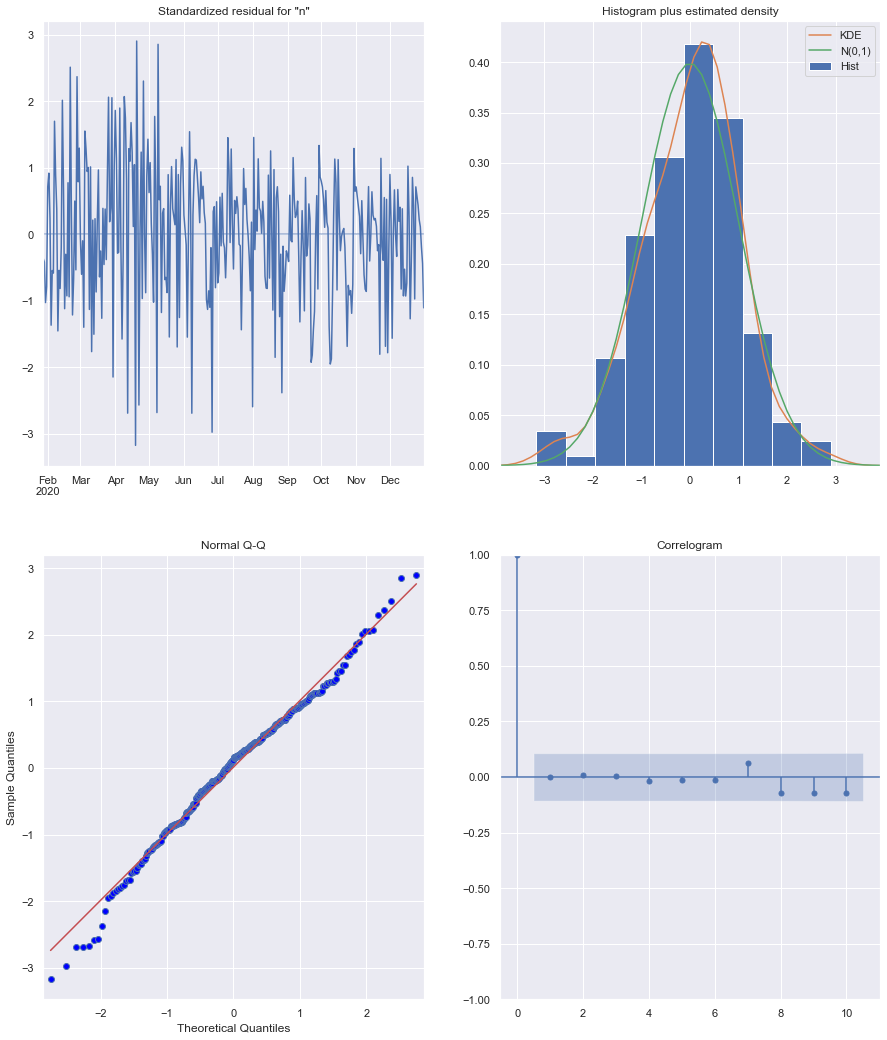

In [288]:
# Call plot_diagnostics() on the results calculated above 
sarimax2_results.plot_diagnostics(figsize=(15, 18))
plt.show()

In [289]:
pred_sarimax2 = sarimax2_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax2_np = pd.Series(np.array(pred_sarimax2).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax2_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax2'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1  predict_sarimax2
2021-01-01  11.735000      60.210796         62.713554         56.983548
2021-01-02  20.541458      79.190262         67.471738         71.470392
2021-01-03  14.311597      81.518166         80.256039         70.913692
2021-01-04  21.697500      83.984605         65.358192         78.150055
2021-01-05  26.341181      83.526857         75.356192         72.991002

In [290]:
sarima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_sarimax1'],
               df_arima_pred['predict_sarimax2'])

In [240]:
p = q = (0, 1, 2)
d = 0
pdq = [(ar, d, ma) for ar in p for ma in q]
pdqs = [(c[0], d, c[2], 30) for c in pdq]

# Iterate and try models:
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(train_d_1d,
                                             order=pdq_combo,
                                             seasonal_order=pdqs_combo,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False
                                             )
            output = model.fit()
            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                #print('Sarima Combos:', (pdq_combo, pdqs_combo), 'AIC:', output.aic)

        except ValueError:
            pass
print(f'\m{"*"*20}\nOptimal Sarima order: {combo}')  

\m********************
Optimal Sarima order: ((1, 0, 2), (1, 0, 2, 30))


In [243]:
sarimax3 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,0,2),
                                    seasonal_order=(1,0,2,30), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                    )

# Fit the model and print results
sarimax3_results = sarimax3.fit()
print(sarimax3_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9963      0.004    262.041      0.000       0.989       1.004
ma.L1         -0.6535      0.061    -10.703      0.000      -0.773      -0.534
ma.L2         -0.1622      0.061     -2.640      0.008      -0.283      -0.042
ar.S.L30       0.4041      0.102      3.974      0.000       0.205       0.603
ma.S.L30      -0.4510      0.129     -3.485      0.000      -0.705      -0.197
ma.S.L60       0.0093      0.066      0.142      0.887      -0.120       0.138
sigma2      2542.7337    239.448     10.619      0.000    2073.424    3012.044


In [244]:
pred_sarimax3 = sarimax3_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax3_np = pd.Series(np.array(pred_sarimax2).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax3_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax3'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1  predict_sarimax2  \
2021-01-01  11.735000      52.818289         53.130030         45.141892   
2021-01-02  20.541458      55.176696         52.163186         45.053484   
2021-01-03  14.311597      52.270150         52.962545         43.444112   
2021-01-04  21.697500      54.479878         42.439687         53.982587   
2021-01-05  26.341181      54.893415         21.145762         47.308161   

            predict_sarimax3  
2021-01-01         45.141892  
2021-01-02         45.053484  
2021-01-03         43.444112  
2021-01-04         53.982587  
2021-01-05         47.308161

In [245]:
sarima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_sarimax1'],
               df_arima_pred['predict_sarimax3'])

In [ ]:
                                    order=(1,1,1),
                                    seasonal_order=(2,1,2,12)

In [255]:
sarimax4 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,1,1),
                                    seasonal_order=(0,0,2,12), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                    )

# Fit the model and print results
sarimax4_results = sarimax4.fit()
print(sarimax4_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2311      0.064      3.587      0.000       0.105       0.357
ma.L1         -0.8705      0.033    -26.588      0.000      -0.935      -0.806
ma.S.L12       0.0239      0.052      0.457      0.647      -0.078       0.126
ma.S.L24      -0.0029      0.050     -0.058      0.954      -0.101       0.095
sigma2      2495.3148    184.489     13.526      0.000    2133.722    2856.907


In [256]:
pred_sarimax4 = sarimax4_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax4_np = pd.Series(np.array(pred_sarimax2).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax4_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax4'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1  predict_sarimax2  \
2021-01-01  11.735000      52.818289         53.130030         50.274188   
2021-01-02  20.541458      55.176696         52.163186         46.468101   
2021-01-03  14.311597      52.270150         52.962545         46.499226   
2021-01-04  21.697500      54.479878         42.439687         46.014405   
2021-01-05  26.341181      54.893415         21.145762         46.228212   

            predict_sarimax3  predict_sarimax4  
2021-01-01         45.141892         50.274188  
2021-01-02         45.053484         46.468101  
2021-01-03         43.444112         46.499226  
2021-01-04         53.982587         46.014405  
2021-01-05         47.308161         46.228212

In [257]:
sarima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_sarimax1'],
               df_arima_pred['predict_sarimax4'])

In [265]:
mae_arima = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_arima'])
mae_sarimax1 = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_sarimax1'])
mae_sarimax2 = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_sarimax2'])
mae_sarimax3 = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_sarimax3'])

print(f'Mean Absolute Error ARIMA : {mae_arima}')
print(f'Mean Absolute Error SARIMAX 1: {mae_sarimax1}')
print(f'Mean Absolute Error SARIMAX 2: {mae_sarimax2}')
print(f'Mean Absolute Error SARIMAX 3: {mae_sarimax3}')

Mean Absolute Error ARIMA : 38.606351332877395
Mean Absolute Error SARIMAX 1: 40.23094384638547
Mean Absolute Error SARIMAX 2: 41.38632128540016
Mean Absolute Error SARIMAX 3: 41.05850210576437


The best SARIMAX parameter is the one in the begining. It doesnt seems to improve beyond that. 
However, current model is not enough to predict the model with high accuracy. In the next step, we will experiment more sophisticated architecture from Deep Neural Network.

### LSTM

In [20]:
# split data into train, test and validation set
train_df_h = df_train['Bondville_IL'].resample('H').mean().fillna(0)
val_df_h = df_test['Bondville_IL'].resample('H').mean()[0:1752]
test_df_h = df_test['Bondville_IL'].resample('H').mean()[1752:]
val.fillna(0, inplace=True)

train.shape, val.shape, test.shape

((8784, 17), (1752, 17), (1752, 17))

In [104]:
train_h_1d = train_df_h['netsolar']

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       ...,
       [6.15816667e+01],
       [9.37833333e+00],
       [1.16666667e-02]])

In [21]:
# Create a univarate sequence
train_h_1d = train_df_h['netsolar'].values
val_h_1d = val_df_h['netsolar'].values
test_h_1d = test_df_h['netsolar'].values
train_h_1d.shape, val_h_1d.shape, test_h_1d.shape

((8784,), (1752,), (1752,))

In [285]:
# Scaling
# sc = MinMaxScaler(feature_range = (0,100))
# train_scaled = sc.fit_transform(np.array(train_h).reshape(-1, 1))
# test_scaled = sc.transform(np.array(test_h).reshape(-1, 1))

In [15]:
train_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
test_seq = [13, 14, 15, 16, 17]

In [16]:
from numpy import array

def split_seq(sequence, n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        # find end of this pattern
        end_ix = i + n_steps
        
        
        # check if ware beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [17]:
# Unit test
X_train_t, y_train_t = split_seq(train_seq, n_steps=3)
X_test_t, y_test_t = split_seq(test_seq, n_steps=3)
X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape

((6, 3), (6,), (2, 3), (2,))

In [25]:
X_train, y_train = split_seq(train_h_1d, n_steps=24)
X_test, y_test = split_seq(test_h_1d, n_steps=24)
X_val, y_val = split_seq(val_h_1d, n_steps=24)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((8760, 24), (8760,), (1728, 24), (1728,), (1728, 24), (1728,))

In [26]:
n_steps = 24
n_features=1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((8760, 24, 1), (8760,), (1728, 24, 1), (1728,), (1728, 24, 1), (1728,))

In [27]:
#  LSTM 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

tf.random.set_seed(389)

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Check GPU
tf.test.gpu_device_name()

''

In [29]:
# Vanilla LSTM 

model = Sequential()
model.add(layers.LSTM(10, activation='relu', input_shape=(n_steps, n_features)))                
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
batch_size =1
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), callbacks=es,
                    epochs=5, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/5
8760/8760 - 18s - loss: 15509.6514 - val_loss: 7081.4976
Epoch 2/5
8760/8760 - 18s - loss: 5132.3809 - val_loss: 4850.5820
Epoch 3/5
8760/8760 - 18s - loss: 3208.3110 - val_loss: 3266.1372
Epoch 4/5
8760/8760 - 18s - loss: 6455.4956 - val_loss: 12841.1865
Epoch 5/5
8760/8760 - 18s - loss: 6029.9658 - val_loss: 4233.1348


In [31]:
pd.DataFrame(history.history)

loss      val_loss
0  15509.651367   7081.497559
1   5132.380859   4850.582031
2   3208.311035   3266.137207
3   6455.495605  12841.186523
4   6029.965820   4233.134766

In [71]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig = go.Figure()
fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['loss'],
                        name='Training Loss')
             )
fig.add_trace(go.Scatter(x=hist['epoch'],
                        y=hist['val_loss'],
                        name='Val Loss')
             )
fig.update_layout(title='Training Result')
fig.show()

Train: 3039.615, Val: 4233.139


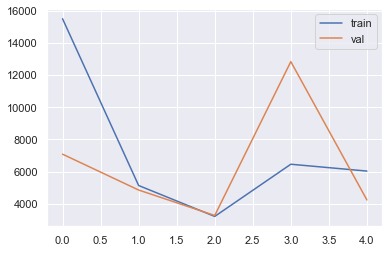

In [32]:
train_acc = model.evaluate(X_train, y_train, verbose=0)
val_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [72]:
testPredict = model.predict(X_test, batch_size=batch_size)
trainPredict = model.predict(X_train, batch_size=batch_size)

In [73]:
def create_pred_df(true_series, prediction):
    
    df_temp = pd.DataFrame(true_series, columns=['netsolar']).reset_index()
    predicted_series = pd.Series(prediction.reshape(-1))
    df_temp['predicted'] = pd.Series(predicted_series, index = df_temp.index)
    
    df_pred = pd.DataFrame(true_series, columns=['netsolar'])
    df_pred['predicted'] = df_temp['predicted'].values
    
    return df_pred

In [74]:
df_pred_test = create_pred_df(test_df_h[['netsolar']], testPredict)
df_pred_train = create_pred_df(train_df_h[['netsolar']], trainPredict)

In [76]:
df_pred_temp = pd.DataFrame(test_h_1d, columns=['netsolar']).reset_index()
predicted = pd.Series(testPredict.reshape(-1))
df_pred_temp['predicted'] = pd.Series(predicted, index = df_pred_temp.index)
df_pred = pd.DataFrame(test_h_1d, columns=['netsolar'])
df_pred['predicted'] = df_pred_temp.predicted.values
df_pred

netsolar  predicted
0       0.060000  -1.860254
1       0.000000  -1.904923
2       0.000000  -3.374117
3       0.000000  -4.013715
4       0.000000  -1.807501
...          ...        ...
1747  699.151667        NaN
1748  613.570000        NaN
1749  462.618333        NaN
1750  348.713333        NaN
1751  177.090000        NaN

[1752 rows x 2 columns]

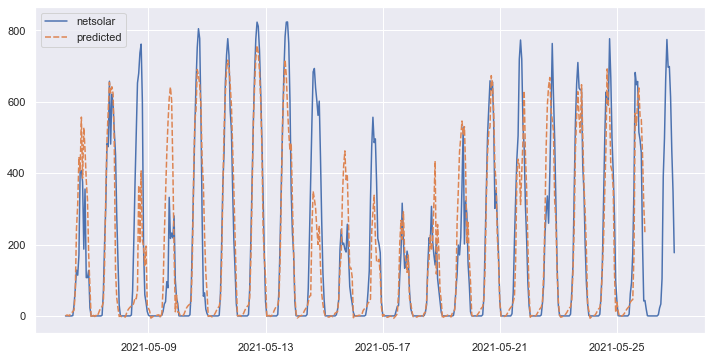

In [77]:
# Simple LSTM result
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred_test[-500:])
plt.legend()

In [96]:
train_h_1d = train_h_1d.reshape(-1, 1)

In [97]:
train_h_1d[-n_steps:].reshape((1, n_steps, n_features)).shape

(1, 24, 1)

In [98]:
pred_list = []
batch = train_h_1d[-n_steps:].reshape((1, n_steps, n_features))
train_h_1d.shape, batch.shape

((8784, 1), (1, 24, 1))

In [99]:
for i in range(n_steps):
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)  

In [105]:
train_h = train_df_h[['netsolar']]
train_h

netsolar
2020-01-01 00:00:00    0.000000
2020-01-01 01:00:00    0.000000
2020-01-01 02:00:00    0.000000
2020-01-01 03:00:00    0.000000
2020-01-01 04:00:00    0.000000
...                         ...
2020-12-31 19:00:00  189.805000
2020-12-31 20:00:00  162.765000
2020-12-31 21:00:00   61.581667
2020-12-31 22:00:00    9.378333
2020-12-31 23:00:00    0.011667

[8784 rows x 1 columns]

In [107]:
from pandas.tseries.offsets import DateOffset
add_dates = [train_h.index[-1] + DateOffset(hours=x) for x in range(0,25) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=train_h.columns)

In [109]:
train_h.index[-1]

Timestamp('2020-12-31 23:00:00', freq='H')

In [118]:
df_predict = pd.DataFrame(pred_list,
                          index=future_dates[-n_steps:].index, columns=['Prediction'])

df_proj = pd.concat([train_h,df_predict], axis=1)

# df_proj[-25:]

In [117]:
plot_data = [
    go.Scatter(
        x=df_proj.index,
        y=df_proj['netsolar'],
        name='actual'
    ),
    go.Scatter(
        x=df_proj.index,
        y=df_proj['Prediction'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title=''
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()
# pyoff.iplot(fig)

In [383]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, lookback=1):
    x,y =[], []
    for i in range(len(dataset) - lookback-1):
        a = dataset[i:(i+lookback), 0]
        x.append(a)
        y.append(dataset[i+lookback, 0])
    return np.array(x), np.array(y)

In [414]:
# X, y = create_dataset(train_h)

In [400]:
# Make X value of the next hour as the y-vlaue
X_train, y_train = (train_h), (train_h.shift(periods=-1, fill_value=train_h[-1]))
X_test, y_test = (test_h), (test_h.shift(periods=-1, fill_value=test_h[-1]))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8784,), (8784,), (3504,), (3504,))

In [410]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [413]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8784, 1, 1), (8784,), (3504, 1, 1), (3504,))

In [415]:
model = Sequential()
model.add(layers.LSTM(10, input_shape=(1, lookback)))                
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [416]:
batch_size =1
es =EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), callbacks=es,
                    epochs=5, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/5
8784/8784 - 6s - loss: 53016.6445 - val_loss: 42029.7383
Epoch 2/5
8784/8784 - 6s - loss: 44681.2500 - val_loss: 35641.1328
Epoch 3/5
8784/8784 - 6s - loss: 38134.7578 - val_loss: 30553.3027
Epoch 4/5
8784/8784 - 6s - loss: 32765.3516 - val_loss: 26347.2832
Epoch 5/5
8784/8784 - 6s - loss: 28418.3262 - val_loss: 22955.5859


Train: 26437.561, Val: 22955.658


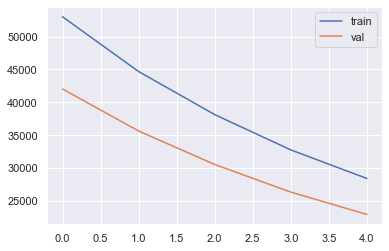

In [417]:
train_acc = model.evaluate(X_train, y_train, verbose=0)
val_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [418]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [438]:
df_pred = pd.DataFrame(test_h, columns=['netsolar'])
predict_tmp = pd.DataFrame(testPredict.reshape(-1), columns=['predicted'])
df_pred['predicted'] = predict_tmp.predicted.values
df_pred

netsolar   predicted
2021-01-01 00:00:00    0.000000    0.634954
2021-01-01 01:00:00    0.000000    0.634954
2021-01-01 02:00:00    0.000000    0.634954
2021-01-01 03:00:00    0.000000    0.634954
2021-01-01 04:00:00    0.000000    0.634954
...                         ...         ...
2021-05-26 19:00:00  699.151667  170.958923
2021-05-26 20:00:00  613.570000  170.958633
2021-05-26 21:00:00  462.618333  170.950043
2021-05-26 22:00:00  348.713333  170.844116
2021-05-26 23:00:00  177.090000  164.957214

[3504 rows x 2 columns]

In [70]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_pred[-100:])
plt.legend()

NameError: name 'df_pred' is not defined

<Figure size 864x432 with 0 Axes>

In [461]:
x_input = np.array([X_test[-1]])
temp_input = list(x_input)
lst_output = []
hours = 24

for day in range(0, hours, 1):
    if(len(temp_input)>1):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1,1,1))       
        yhat = model.predict(x_input, verbose=0)
        val = yhat.reshape(-1)
        temp_input.append(val)
        temp_input = temp_input[1:]
        lst_output.append(val)
        
    else:
        x_input = x_input.reshape((1, 1, 1))
        yhat = model.predict(x_input, verbose=0)
        val = yhat.reshape(-1)
        temp_input.append(val)
        lst_output.append(val)    
    
forecasts =np.array(lst_output).reshape(-1)

In [462]:
len(forecasts)

24

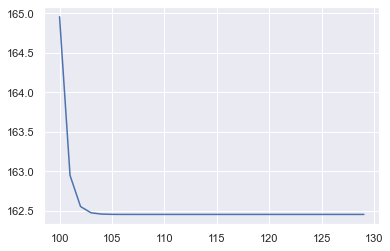

In [449]:
plt.plot(np.arange(100, 100+days), forecasts)
# plt.figure(figsize=(12,6))
# sns.lineplot(data=df_pred[-100:])

In [458]:
def insert_end(Xin, new_input, timestep):
    for i in range(timestep-1):
        Xin[:, i, :] = Xin[: i+1, :]
    Xin[:, timestep-1, :] = new_input
    return Xin

In [460]:
first = 100
future = 200
forecast = []
Xin = np.array([X_test[-1]])
for i in range(future):
    out = model.predict(Xin, batch_size=1)
    forecast.append(out[0,0])
    Xin = insert_end(Xin, out[0,0], timestep=30)    

IndexError: index 1 is out of bounds for axis 1 with size 1

In [457]:
first = 100
future = 200
forecast = []
Xin = X_test[first:first+1, :, :]
Xin

array([[[0.]]])

In [419]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_train)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(X_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[lookback:len(trainPredict)+lookback, :] = testPredict

# Plot baseline and predictions
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


ValueError: could not broadcast input array from shape (8784,1) into shape (8783,1,1)

In [261]:
x_input = np.array([X_test[-1]])
temp_input=list(x_input)
lst_output=[]
months = 12

for month in range(0, months ,1):
    
    if(len(temp_input)>1):
        x_input=np.array(temp_input[1:])
        #print(x_input)
        x_input = x_input.reshape((1, 1, 1))
        #print(x_input)
        yhat = model2.predict(x_input, verbose=0)
        val = yhat.reshape(-1)
        temp_input.append(val)
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(val)
        
    else:
        x_input = x_input.reshape((1,  1, 1))
        yhat = model2.predict(x_input, verbose=0)
        val = yhat.reshape(-1)
        temp_input.append(val)
        lst_output.append(val)
        
    

forecasts =np.array(lst_output).reshape(-1)

ValueError: cannot reshape array of size 24 into shape (1,1,1)

In [122]:
from statsmodels.tsa.api import VAR
# model = VAR(X)
# results = model.fit(maxlags=15, ic='aic')
# results.summary()

# Forecasting
# lag_order = results.k_ar
# results.forecast(X.values[-lag_order:], 5)

# results.plot_forecast(20)

In [ ]:
import math

def fill_nan(df, location):
    '''
    Function to derive netsolar from totalnet using linear regression and vice-versa
    '''    
    df = df.replace(to_replace=-9999.9, value=np.nan)
    
    if location == 'Bondville_IL':
        df['totalnet_fill'] = 0.77 * df.netsolar - 22 
        df['netsolar_fill'] = (df.totalnet + 22)/0.77        
        
    elif location == 'Boulder_CO':
        df['totalnet_fill'] = 0.7 * df.netsolar - 42  
        df['netsolar_fill'] = (df.totalnet + 42)/0.7
        
    elif location == 'Desert_Rock_NV':
        df['totalnet_fill'] = 0.6 * df.netsolar - 48
        df['netsolar_fill'] = (df.totalnet + 48)/0.6
    
    elif location == 'Fort_Peck_MT':
        df['totalnet_fill'] = 0.75 * df.netsolar - 33
        df['netsolar_fill'] = (df.totalnet + 33)/0.75
        
    elif location == 'Goodwin_Creek_MS':
        df['totalnet_fill'] = 0.76 * df.netsolar - 17
        df['netsolar_fill'] = (df.totalnet + 17)/0.76
        
    elif location == 'Penn_State_PA':
        df['totalnet_fill'] = 0.75 * df.netsolar - 21 
        df['netsolar_fill'] = (df.totalnet + 21)/0.75
        
    else:
        df['totalnet_fill'] = 0.78 * df.netsolar - 29
        df['netsolar_fill'] = (df.totalnet + 29)/0.78
        
    df['totalnet'] = df['totalnet'].fillna(df['totalnet_fill'])
    df['netsolar'] = df['netsolar'].fillna(df['netsolar_fill'])
    
    return df